Cell 1: Setup and Imports

In [1]:
# Install required packages
!pip install torch torchvision -q
!pip install Pillow -q
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install pandas -q
!pip install seaborn -q

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms as transforms
import os
import zipfile
import tarfile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
import random
import time
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU available: True
GPU: Tesla T4


##Cell 2: Dataset Upload and Extraction

In [3]:
from google.colab import files

print("Upload your lfw-funneled.tgz file")
uploaded = files.upload()

print("\nFile uploaded successfully!")
print("Now extracting...")

# Create directory
!mkdir -p data

# Extract using tar command
!tar -xzf lfw-funneled.tgz -C data/

print("\nExtraction complete!")
print("\nChecking extracted files:")

# Check what was extracted
!find data/ -type f -name "*.jpg" | head -5
!find data/ -type d | head -10

print("\nDirectory structure:")
!ls -la data/

Upload your lfw-funneled.tgz file


Saving lfw-funneled.tgz to lfw-funneled.tgz

File uploaded successfully!
Now extracting...

Extraction complete!

Checking extracted files:
data/lfw_funneled/Jorge_Valdano/Jorge_Valdano_0002.jpg
data/lfw_funneled/Jorge_Valdano/Jorge_Valdano_0001.jpg
data/lfw_funneled/Antonio_Elias_Saca/Antonio_Elias_Saca_0001.jpg
data/lfw_funneled/Myung_Yang/Myung_Yang_0001.jpg
data/lfw_funneled/Ismail_Abu_Shanab/Ismail_Abu_Shanab_0001.jpg
data/
data/lfw_funneled
data/lfw_funneled/Jorge_Valdano
data/lfw_funneled/Antonio_Elias_Saca
data/lfw_funneled/Myung_Yang
data/lfw_funneled/Ismail_Abu_Shanab
data/lfw_funneled/Terry_Lynn_Barton
data/lfw_funneled/Florencia_Kirchner
data/lfw_funneled/Roberto_Guaterroma
data/lfw_funneled/Basdeo_Panday

Directory structure:
total 208
drwxr-xr-x    3 root  root    4096 Dec  9 12:02 .
drwxr-xr-x    1 root  root    4096 Dec  9 12:02 ..
drwxr-xr-x 5751 25112 users 200704 Nov 13  2007 lfw_funneled


In [6]:
# Clean up any existing data directory
!rm -rf data
!rm -rf lfw_funneled
!rm -rf lfw

# Create directory and extract
!mkdir -p data

# Extract the file
for filename in uploaded.keys():
    print(f"Extracting {filename}...")
    !tar -xzf "{filename}" 2>/dev/null || echo "Trying alternative extraction..."

    # If extraction didn't work with tar -xzf, try with tar -xzvf
    if not os.path.exists('lfw_funneled') and not os.path.exists('lfw'):
        !tar -xzvf "{filename}" 2>/dev/null || echo "Extraction may have failed"

print("\nChecking what was extracted...")

# List all directories and files
print("\nCurrent directory contents:")
!ls -la

print("\nSearching for extracted files...")
!find . -maxdepth 2 -type d -name "*lfw*" 2>/dev/null || echo "No LFW directories found at top level"
!find . -maxdepth 2 -type d -name "*funneled*" 2>/dev/null || echo "No funneled directories found"

# Move everything to data directory if needed
!mv lfw_funneled data/ 2>/dev/null || echo "lfw_funneled not found"
!mv lfw data/ 2>/dev/null || echo "lfw not found"

print("\nContents of data directory:")
!ls -la data/ 2>/dev/null || echo "Data directory is empty"

# Try to find JPG files
print("\nSearching for JPG files...")
!find . -name "*.jpg" -type f | head -5 2>/dev/null || echo "No JPG files found"

Extracting lfw-funneled.tgz...

Checking what was extracted...

Current directory contents:
total 237868
drwxr-xr-x    1 root  root       4096 Dec  9 12:06 .
drwxr-xr-x    1 root  root       4096 Dec  9 11:41 ..
drwxr-xr-x    4 root  root       4096 Nov 20 14:30 .config
drwxr-xr-x    2 root  root       4096 Dec  9 12:06 data
drwxr-xr-x 5751 25112 users    200704 Nov 13  2007 lfw_funneled
-rw-r--r--    1 root  root  243346528 Dec  9 12:02 lfw-funneled.tgz
drwxr-xr-x    1 root  root       4096 Nov 20 14:30 sample_data

Searching for extracted files...
./lfw_funneled
./lfw_funneled
lfw not found

Contents of data directory:
total 208
drwxr-xr-x    3 root  root    4096 Dec  9 12:06 .
drwxr-xr-x    1 root  root    4096 Dec  9 12:06 ..
drwxr-xr-x 5751 25112 users 200704 Nov 13  2007 lfw_funneled

Searching for JPG files...
./data/lfw_funneled/Jorge_Valdano/Jorge_Valdano_0002.jpg
./data/lfw_funneled/Jorge_Valdano/Jorge_Valdano_0001.jpg
./data/lfw_funneled/Antonio_Elias_Saca/Antonio_Elias_Saca

##Cell 3: Dataset Preparation

In [9]:
import glob

print("Found LFW dataset successfully!")
print("Dataset path: ./data/lfw_funneled")

# Set the correct dataset path
dataset_path = 'data/lfw_funneled'

# Verify the path exists
if os.path.exists(dataset_path):
    print(f"\n✅ Dataset path exists: {dataset_path}")

    # Count total directories (people)
    all_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Total number of people (directories): {len(all_dirs)}")

    # Count total images
    jpg_files = glob.glob(f"{dataset_path}/**/*.jpg", recursive=True)
    print(f"Total number of JPG files: {len(jpg_files)}")

    # Show some sample directories
    print(f"\nFirst 10 people/directories:")
    for i, dir_name in enumerate(all_dirs[:10]):
        person_dir = os.path.join(dataset_path, dir_name)
        person_images = [f for f in os.listdir(person_dir) if f.lower().endswith('.jpg')]
        print(f"  {i+1}. {dir_name}: {len(person_images)} images")

        # Show first image name as example
        if person_images:
            print(f"     Sample: {person_images[0]}")

    # Check distribution of images per person
    print(f"\nAnalyzing image distribution...")
    images_per_person = []
    for dir_name in all_dirs:
        person_dir = os.path.join(dataset_path, dir_name)
        person_images = [f for f in os.listdir(person_dir) if f.lower().endswith('.jpg')]
        images_per_person.append(len(person_images))

    print(f"  Average images per person: {np.mean(images_per_person):.2f}")
    print(f"  Minimum images per person: {min(images_per_person)}")
    print(f"  Maximum images per person: {max(images_per_person)}")

    # Count how many people have at least 2 images (for training)
    people_with_at_least_2 = sum(1 for count in images_per_person if count >= 2)
    print(f"\n  People with at least 2 images: {people_with_at_least_2}")
    print(f"  People with only 1 image: {len(all_dirs) - people_with_at_least_2}")

    # Show people with most images
    print(f"\nTop 5 people with most images:")
    dir_image_counts = [(dir_name, len([f for f in os.listdir(os.path.join(dataset_path, dir_name))
                                       if f.lower().endswith('.jpg')]))
                       for dir_name in all_dirs]
    dir_image_counts.sort(key=lambda x: x[1], reverse=True)

    for i, (dir_name, count) in enumerate(dir_image_counts[:5]):
        print(f"  {i+1}. {dir_name}: {count} images")

else:
    print(f"❌ Dataset path does not exist: {dataset_path}")

Found LFW dataset successfully!
Dataset path: ./data/lfw_funneled

✅ Dataset path exists: data/lfw_funneled
Total number of people (directories): 5749
Total number of JPG files: 13233

First 10 people/directories:
  1. Jorge_Valdano: 2 images
     Sample: Jorge_Valdano_0002.jpg
  2. Antonio_Elias_Saca: 1 images
     Sample: Antonio_Elias_Saca_0001.jpg
  3. Myung_Yang: 1 images
     Sample: Myung_Yang_0001.jpg
  4. Ismail_Abu_Shanab: 1 images
     Sample: Ismail_Abu_Shanab_0001.jpg
  5. Terry_Lynn_Barton: 1 images
     Sample: Terry_Lynn_Barton_0001.jpg
  6. Florencia_Kirchner: 1 images
     Sample: Florencia_Kirchner_0001.jpg
  7. Roberto_Guaterroma: 1 images
     Sample: Roberto_Guaterroma_0001.jpg
  8. Basdeo_Panday: 1 images
     Sample: Basdeo_Panday_0001.jpg
  9. Romario_Farias: 1 images
     Sample: Romario_Farias_0001.jpg
  10. Robin_Wright_Penn: 1 images
     Sample: Robin_Wright_Penn_0001.jpg

Analyzing image distribution...
  Average images per person: 2.30
  Minimum images p

##Cell 4: Dataset Class and Transformations

In [10]:
# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Simple dataset class
class SimpleFaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a dummy image if loading fails
            image = Image.new('RGB', (160, 160), color='white')

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image, label

# Collect all image paths and labels
print("Collecting image paths and labels...")

image_paths = []
labels = []
label_to_name = {}
name_to_label = {}
current_label = 0

if dataset_path and os.path.exists(dataset_path):
    print(f"Scanning directory: {dataset_path}")

    # Get all directories (people's names)
    all_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Found {len(all_dirs)} directories")

    # Process each directory
    for person_name in all_dirs:
        person_dir = os.path.join(dataset_path, person_name)

        # Get all JPG files in this directory
        image_files = [f for f in os.listdir(person_dir) if f.lower().endswith('.jpg')]

        # Only include people with at least 2 images (for training)
        if len(image_files) >= 2:
            name_to_label[person_name] = current_label
            label_to_name[current_label] = person_name

            # Add all images for this person
            for img_name in image_files:
                img_path = os.path.join(person_dir, img_name)
                image_paths.append(img_path)
                labels.append(current_label)

            current_label += 1

            # Show progress for first few people
            if current_label <= 5:
                print(f"  Added {person_name}: {len(image_files)} images")

    print(f"\n✅ Data collection complete!")
    print(f"Total images collected: {len(image_paths)}")
    print(f"Total people/classes: {len(label_to_name)}")

    if len(image_paths) > 0:
        # Show statistics
        label_counts = {}
        for label in labels:
            label_counts[label] = label_counts.get(label, 0) + 1

        print(f"\n📊 Statistics:")
        print(f"  Average images per person: {np.mean(list(label_counts.values())):.2f}")
        print(f"  Minimum images per person: {min(label_counts.values())}")
        print(f"  Maximum images per person: {max(label_counts.values())}")

        # Show distribution
        print(f"\n📈 Distribution of images per person:")
        counts_by_frequency = {}
        for count in label_counts.values():
            counts_by_frequency[count] = counts_by_frequency.get(count, 0) + 1

        for count in sorted(counts_by_frequency.keys()):
            print(f"  {count} images: {counts_by_frequency[count]} people")

        # Show first few image paths as verification
        print(f"\n🔍 Sample image paths:")
        for i in range(min(3, len(image_paths))):
            print(f"  {image_paths[i]}")

        # Show some sample people
        print(f"\n👤 Sample people in dataset:")
        sample_labels = list(label_to_name.keys())[:5]
        for label in sample_labels:
            person_name = label_to_name[label]
            count = label_counts[label]
            print(f"  {person_name}: {count} images (Label: {label})")
    else:
        print("❌ No images collected! Check the directory structure.")
else:
    print(f"❌ Dataset path does not exist: {dataset_path}")

# Save the label mappings for later use
if len(label_to_name) > 0:
    print(f"\n💾 Label mappings saved:")
    print(f"  Number of classes: {len(label_to_name)}")
    print(f"  First 5 mappings: {list(label_to_name.items())[:5]}")

Scanning directory: data/lfw_funneled
Found 5749 directories
  Added Jorge_Valdano: 2 images
  Added Dick_Latessa: 2 images
  Added Rod_Blagojevich: 2 images
  Added Ahmad_Masood: 2 images
  Added Charlie_Zaa: 2 images

✅ Data collection complete!
Total images collected: 9164
Total people/classes: 1680

📊 Statistics:
  Average images per person: 5.45
  Minimum images per person: 2
  Maximum images per person: 530

📈 Distribution of images per person:
  2 images: 779 people
  3 images: 291 people
  4 images: 187 people
  5 images: 112 people
  6 images: 55 people
  7 images: 39 people
  8 images: 33 people
  9 images: 26 people
  10 images: 15 people
  11 images: 16 people
  12 images: 10 people
  13 images: 11 people
  14 images: 10 people
  15 images: 11 people
  16 images: 3 people
  17 images: 8 people
  18 images: 5 people
  19 images: 7 people
  20 images: 5 people
  21 images: 4 people
  22 images: 5 people
  23 images: 3 people
  24 images: 3 people
  25 images: 1 people
  26 im

##Cell 5: Data Splitting

In [11]:
if len(image_paths) > 0 and len(label_to_name) > 0:
    # Split indices
    indices = list(range(len(image_paths)))
    train_indices, val_indices = train_test_split(
        indices,
        test_size=0.2,
        stratify=labels,
        random_state=42
    )

    print(f"✅ Data split complete!")
    print(f"Training samples: {len(train_indices)}")
    print(f"Validation samples: {len(val_indices)}")
    print(f"Total samples: {len(image_paths)}")

    # Create datasets
    train_dataset = SimpleFaceDataset(
        [image_paths[i] for i in train_indices],
        [labels[i] for i in train_indices],
        transform_train
    )

    val_dataset = SimpleFaceDataset(
        [image_paths[i] for i in val_indices],
        [labels[i] for i in val_indices],
        transform_val
    )

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    print(f"\n📊 Data loaders created:")
    print(f"Batch size: {batch_size}")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")

    # Test one batch
    print("\n🧪 Testing one batch...")
    for images, labels_batch in train_loader:
        print(f"✅ Batch loaded successfully!")
        print(f"  Image shape: {images.shape}")  # Should be [batch_size, 3, 160, 160]
        print(f"  Label shape: {labels_batch.shape}")
        print(f"  Image range: [{images.min():.3f}, {images.max():.3f}]")
        print(f"  Unique labels in batch: {torch.unique(labels_batch)}")

        # Show sample image stats
        print(f"\n📷 Sample image statistics:")
        print(f"  Mean: {images.mean().item():.3f}")
        print(f"  Std: {images.std().item():.3f}")
        print(f"  Min pixel value: {images.min().item():.3f}")
        print(f"  Max pixel value: {images.max().item():.3f}")
        break

    print("\n🎉 Dataset preparation complete! Ready for training.")
else:
    print("❌ Cannot proceed without images!")
    print(f"Image paths: {len(image_paths)}")
    print(f"Label mappings: {len(label_to_name)}")

✅ Data split complete!
Training samples: 7331
Validation samples: 1833
Total samples: 9164

📊 Data loaders created:
Batch size: 32
Number of training batches: 230
Number of validation batches: 58

🧪 Testing one batch...
✅ Batch loaded successfully!
  Image shape: torch.Size([32, 3, 160, 160])
  Label shape: torch.Size([32])
  Image range: [-2.118, 2.640]
  Unique labels in batch: tensor([  59,   81,  120,  131,  146,  206,  246,  269,  279,  299,  355,  409,
         489,  512,  518,  543,  615,  619,  746,  769,  851,  874, 1133, 1178,
        1264, 1289, 1376, 1436, 1480, 1605])

📷 Sample image statistics:
  Mean: -0.425
  Std: 1.202
  Min pixel value: -2.118
  Max pixel value: 2.640

🎉 Dataset preparation complete! Ready for training.


##Cell 6: CosFace Loss and Model Architecture

In [12]:
class CosFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin=0.35, scale=64):
        super(CosFaceLoss, self).__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale

        # Weight matrix for classification
        self.W = nn.Parameter(torch.FloatTensor(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.W)

    def forward(self, embeddings, labels):
        # Normalize embeddings and weights
        embeddings_norm = F.normalize(embeddings, p=2, dim=1)
        W_norm = F.normalize(self.W, p=2, dim=1)

        # Calculate cosine similarity
        cosine = F.linear(embeddings_norm, W_norm)

        # Apply CosFace margin
        one_hot = torch.zeros_like(cosine)
        one_hot.scatter_(1, labels.view(-1, 1), 1)

        output = self.scale * (cosine - one_hot * self.margin)

        # Calculate cross-entropy loss
        loss = F.cross_entropy(output, labels)

        return loss, cosine

class FaceNet(nn.Module):
    def __init__(self, embedding_size=512, pretrained=True):
        super(FaceNet, self).__init__()

        # Use ResNet50 as backbone
        self.backbone = models.resnet50(pretrained=pretrained)

        # Remove the last fully connected layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Add embedding layer
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )

    def forward(self, x):
        # Extract features
        x = self.backbone(x)
        x = x.view(x.size(0), -1)

        # Get embeddings
        embedding = self.fc(x)

        return embedding

# Test the model with a dummy input
if len(image_paths) > 0 and len(label_to_name) > 0:
    print("🧪 Testing model with dummy input...")
    dummy_input = torch.randn(2, 3, 160, 160)
    model = FaceNet(embedding_size=512)
    output = model(dummy_input)
    print(f"✅ Model test successful!")
    print(f"  Input shape: {dummy_input.shape}")
    print(f"  Output embedding shape: {output.shape}")

    # Test CosFace loss
    num_classes = len(label_to_name)
    print(f"\n🧪 Testing CosFace loss with {num_classes} classes...")
    cosface = CosFaceLoss(num_classes, 512)
    dummy_labels = torch.tensor([0, 1])
    loss, logits = cosface(output, dummy_labels)
    print(f"✅ CosFace loss test successful!")
    print(f"  Loss value: {loss.item():.4f}")
    print(f"  Logits shape: {logits.shape}")
    print(f"  Number of classes in CosFace: {num_classes}")
else:
    print("❌ Cannot test model without data!")

🧪 Testing model with dummy input...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


✅ Model test successful!
  Input shape: torch.Size([2, 3, 160, 160])
  Output embedding shape: torch.Size([2, 512])

🧪 Testing CosFace loss with 1680 classes...
✅ CosFace loss test successful!
  Loss value: 37.1159
  Logits shape: torch.Size([2, 1680])
  Number of classes in CosFace: 1680


##Cell 7: Training Functions

In [13]:
def train_epoch(model, train_loader, cosface_loss, optimizer, device, epoch):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        embeddings = model(images)
        loss, logits = cosface_loss(embeddings, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(logits, 1)
        correct = (predicted == labels).sum().item()

        total_loss += loss.item()
        total_correct += correct
        total_samples += labels.size(0)

        if batch_idx % 20 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.item():.4f}\t'
                  f'Acc: {100. * correct / labels.size(0):.2f}%')

    avg_loss = total_loss / len(train_loader)
    avg_acc = 100. * total_correct / total_samples

    return avg_loss, avg_acc

def validate(model, val_loader, cosface_loss, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            embeddings = model(images)
            loss, logits = cosface_loss(embeddings, labels)

            _, predicted = torch.max(logits, 1)
            correct = (predicted == labels).sum().item()

            total_loss += loss.item()
            total_correct += correct
            total_samples += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    avg_acc = 100. * total_correct / total_samples

    return avg_loss, avg_acc

print("✅ Training functions defined!")
print("Functions available:")
print("  - train_epoch(): Train for one epoch")
print("  - validate(): Validate the model")

✅ Training functions defined!
Functions available:
  - train_epoch(): Train for one epoch
  - validate(): Validate the model


##Cell 8: Training Loop

In [14]:
if len(image_paths) > 0 and len(label_to_name) > 0:
    # Initialize model
    embedding_size = 512
    num_classes = len(label_to_name)

    print(f"\n🚀 Initializing training...")
    print(f"📊 Training Configuration:")
    print(f"  Number of classes: {num_classes}")
    print(f"  Embedding size: {embedding_size}")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Validation samples: {len(val_dataset)}")
    print(f"  Device: {device}")

    model = FaceNet(embedding_size=embedding_size).to(device)
    cosface_loss = CosFaceLoss(num_classes, embedding_size, margin=0.35, scale=64).to(device)

    # Optimizer
    optimizer = optim.Adam([
        {'params': model.parameters()},
        {'params': cosface_loss.parameters()}
    ], lr=0.001, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Training parameters
    num_epochs = 15  # Reduced for faster training
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"\n{'='*60}")
    print("🎯 Starting Training")
    print(f"{'='*60}")
    print(f"  Total epochs: {num_epochs}")
    print(f"  Initial learning rate: {optimizer.param_groups[0]['lr']}")
    print(f"  Margin (CosFace): {cosface_loss.margin}")
    print(f"  Scale (CosFace): {cosface_loss.scale}")
    print(f"{'='*60}")

    # Training loop
    for epoch in range(1, num_epochs + 1):
        print(f"\n{'='*50}")
        print(f"📅 Epoch {epoch}/{num_epochs}")
        print(f"{'='*50}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, cosface_loss, optimizer, device, epoch)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc = validate(model, val_loader, cosface_loss, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update learning rate
        scheduler.step()

        print(f"\n📊 Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if epoch == 1 or val_acc >= max(val_accs):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'cosface_state_dict': cosface_loss.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc,
                'label_to_name': label_to_name,
                'name_to_label': name_to_label,
                'num_classes': num_classes,
                'embedding_size': embedding_size,
                'transform': transform_val
            }, 'best_cosface_model.pth')
            print(f"  💾 Saved best model with val accuracy: {val_acc:.2f}%")

    print(f"\n{'='*60}")
    print("🎉 Training completed!")
    print(f"{'='*60}")

    # Save final model
    torch.save({
        'epoch': num_epochs,
        'model_state_dict': model.state_dict(),
        'cosface_state_dict': cosface_loss.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'label_to_name': label_to_name,
        'name_to_label': name_to_label,
        'num_classes': num_classes,
        'embedding_size': embedding_size,
        'transform': transform_val
    }, 'cosface_final_model.pth')

    print("✅ Final model saved as 'cosface_final_model.pth'")

    # Print final statistics
    print(f"\n📈 Final Statistics:")
    print(f"  Best Validation Accuracy: {max(val_accs):.2f}% (Epoch {val_accs.index(max(val_accs)) + 1})")
    print(f"  Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"  Final Validation Accuracy: {val_accs[-1]:.2f}%")

else:
    print("❌ Cannot start training without data!")
    print(f"Image paths: {len(image_paths)}")
    print(f"Label mappings: {len(label_to_name)}")


🚀 Initializing training...
📊 Training Configuration:
  Number of classes: 1680
  Embedding size: 512
  Training samples: 7331
  Validation samples: 1833
  Device: cuda

🎯 Starting Training
  Total epochs: 15
  Initial learning rate: 0.001
  Margin (CosFace): 0.35
  Scale (CosFace): 64

📅 Epoch 1/15
Epoch: 1 [0/7331 (0%)]	Loss: 33.7592	Acc: 0.00%
Epoch: 1 [640/7331 (9%)]	Loss: 32.9672	Acc: 0.00%
Epoch: 1 [1280/7331 (17%)]	Loss: 31.8649	Acc: 0.00%
Epoch: 1 [1920/7331 (26%)]	Loss: 33.0673	Acc: 0.00%
Epoch: 1 [2560/7331 (35%)]	Loss: 32.4719	Acc: 3.12%
Epoch: 1 [3200/7331 (43%)]	Loss: 32.3223	Acc: 3.12%
Epoch: 1 [3840/7331 (52%)]	Loss: 31.3941	Acc: 0.00%
Epoch: 1 [4480/7331 (61%)]	Loss: 32.5491	Acc: 3.12%
Epoch: 1 [5120/7331 (70%)]	Loss: 30.9158	Acc: 6.25%
Epoch: 1 [5760/7331 (78%)]	Loss: 33.3961	Acc: 0.00%
Epoch: 1 [6400/7331 (87%)]	Loss: 33.8350	Acc: 3.12%
Epoch: 1 [7040/7331 (96%)]	Loss: 32.8564	Acc: 0.00%

📊 Epoch 1 Summary:
  Train Loss: 32.4834, Train Acc: 1.58%
  Val Loss: 32.2597, 

##Cell 9: Training Visualization

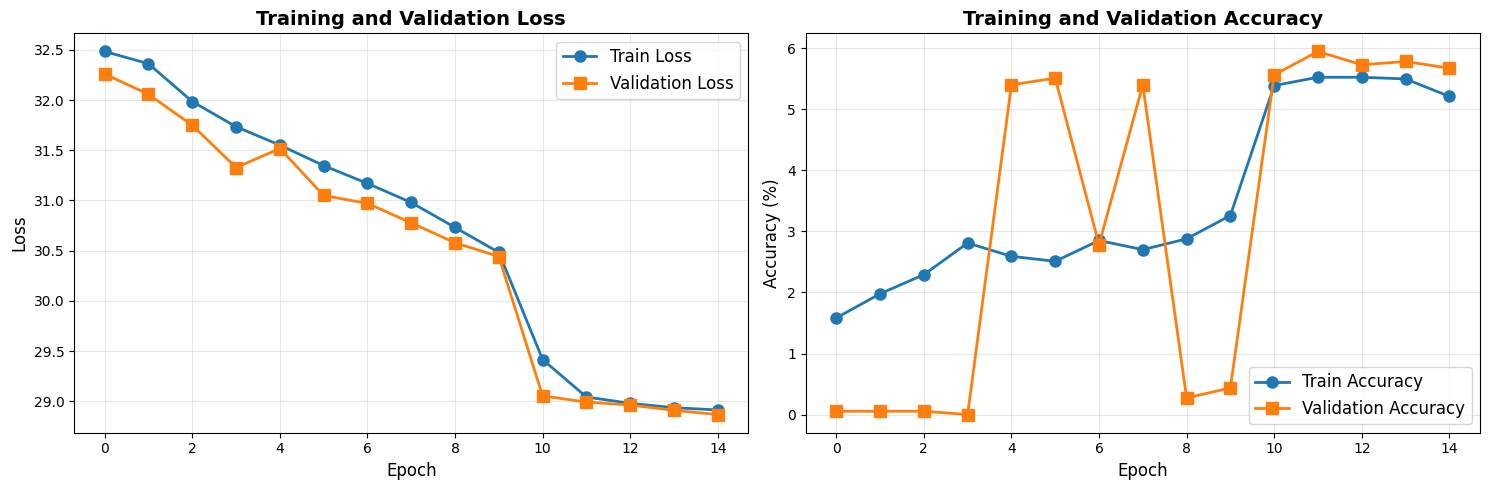

📊 Training Summary:
  Final Training Accuracy: 5.21%
  Final Validation Accuracy: 5.67%
  Best Validation Accuracy: 5.95% (Epoch 12)

🧪 Testing sample predictions...


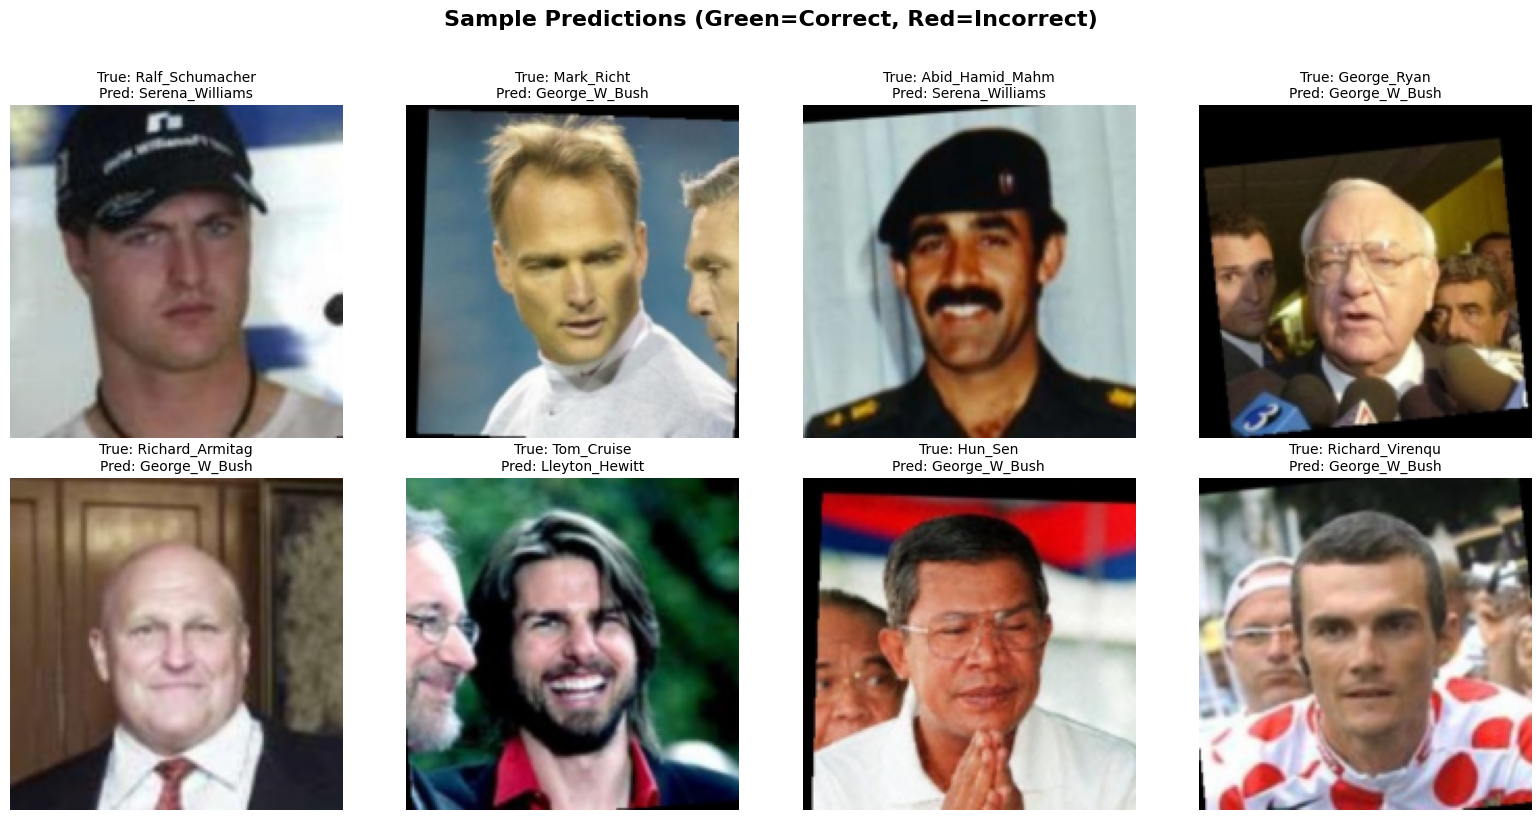


✅ Sample batch accuracy: 0.0% (0/8 correct)


In [15]:
if len(image_paths) > 0 and 'train_losses' in locals() and len(train_losses) > 0:
    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    axes[0].plot(train_losses, label='Train Loss', marker='o', linewidth=2, markersize=8)
    axes[0].plot(val_losses, label='Validation Loss', marker='s', linewidth=2, markersize=8)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=12)
    axes[0].grid(True, alpha=0.3)
    axes[0].tick_params(labelsize=10)

    # Accuracy plot
    axes[1].plot(train_accs, label='Train Accuracy', marker='o', linewidth=2, markersize=8)
    axes[1].plot(val_accs, label='Validation Accuracy', marker='s', linewidth=2, markersize=8)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Accuracy (%)', fontsize=12)
    axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=12)
    axes[1].grid(True, alpha=0.3)
    axes[1].tick_params(labelsize=10)

    plt.tight_layout()
    plt.show()

    # Print final metrics
    print("📊 Training Summary:")
    print(f"  Final Training Accuracy: {train_accs[-1]:.2f}%")
    print(f"  Final Validation Accuracy: {val_accs[-1]:.2f}%")
    print(f"  Best Validation Accuracy: {max(val_accs):.2f}% (Epoch {val_accs.index(max(val_accs)) + 1})")

    # Show sample predictions
    print("\n🧪 Testing sample predictions...")
    model.eval()

    # Get a batch of validation data
    sample_images, sample_labels = next(iter(val_loader))
    sample_images = sample_images[:8].to(device)
    sample_labels = sample_labels[:8]

    with torch.no_grad():
        embeddings = model(sample_images)
        # Use dummy labels for prediction
        dummy_labels = torch.zeros(8, dtype=torch.long).to(device)
        _, logits = cosface_loss(embeddings, dummy_labels)
        _, predictions = torch.max(logits, 1)

    # Display results
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for idx in range(8):
        # Denormalize image
        img = sample_images[idx].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = torch.clamp(img, 0, 1)

        # Convert to numpy for display
        img_np = img.permute(1, 2, 0).numpy()

        # Get prediction info
        true_label = sample_labels[idx].item()
        pred_label = predictions[idx].item()
        true_name = label_to_name.get(true_label, f"Person_{true_label}")
        pred_name = label_to_name.get(pred_label, f"Person_{pred_label}")

        axes[idx].imshow(img_np)
        axes[idx].set_title(f"True: {true_name[:15]}\nPred: {pred_name[:15]}", fontsize=10)
        axes[idx].axis('off')

        # Highlight correct/incorrect predictions
        if true_label == pred_label:
            axes[idx].patch.set_edgecolor('green')
            axes[idx].patch.set_linewidth(3)
        else:
            axes[idx].patch.set_edgecolor('red')
            axes[idx].patch.set_linewidth(3)

    plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

    # Calculate accuracy on this batch
    correct = (predictions.cpu() == sample_labels).sum().item()
    batch_accuracy = 100. * correct / 8
    print(f"\n✅ Sample batch accuracy: {batch_accuracy:.1f}% ({correct}/8 correct)")

else:
    print("No training history to display!")
    if len(image_paths) == 0:
        print("❌ No images found!")
    if 'train_losses' not in locals():
        print("❌ Training hasn't been run yet!")

##**train again with Better Training Strategy for good accuracy**

##cell-10: Few-Shot Learning with Triplet Loss

In [19]:
# Cell 16: Triplet Loss Implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import random

class TripletFaceDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, num_triplets=10000):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.num_triplets = num_triplets

        # Group images by label
        self.label_to_indices = {}
        for idx, label in enumerate(labels):
            if label not in self.label_to_indices:
                self.label_to_indices[label] = []
            self.label_to_indices[label].append(idx)

        # Create triplets
        self.triplets = self.generate_triplets(num_triplets)

    def generate_triplets(self, num_triplets):
        triplets = []
        labels_list = list(self.label_to_indices.keys())

        for _ in range(num_triplets):
            # Anchor and positive from same class
            anchor_label = random.choice(labels_list)
            while len(self.label_to_indices[anchor_label]) < 2:
                anchor_label = random.choice(labels_list)

            anchor_idx, positive_idx = random.sample(self.label_to_indices[anchor_label], 2)

            # Negative from different class
            negative_label = random.choice(labels_list)
            while negative_label == anchor_label:
                negative_label = random.choice(labels_list)

            negative_idx = random.choice(self.label_to_indices[negative_label])

            triplets.append((anchor_idx, positive_idx, negative_idx))

        return triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        anchor_idx, positive_idx, negative_idx = self.triplets[idx]

        anchor_img = Image.open(self.image_paths[anchor_idx]).convert('RGB')
        positive_img = Image.open(self.image_paths[positive_idx]).convert('RGB')
        negative_img = Image.open(self.image_paths[negative_idx]).convert('RGB')

        if self.transform:
            anchor_img = self.transform(anchor_img)
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = F.pairwise_distance(anchor, positive, 2)
        distance_negative = F.pairwise_distance(anchor, negative, 2)

        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

# Create triplet dataset
print("\n🔄 Creating Triplet Dataset...")
triplet_dataset = TripletFaceDataset(
    image_paths, labels,
    transform=transform_train,
    num_triplets=5000
)

triplet_loader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)

print(f"✅ Created {len(triplet_dataset)} triplets")
print(f"  Batch size: 32")
print(f"  Number of batches: {len(triplet_loader)}")


🔄 Creating Triplet Dataset...
✅ Created 5000 triplets
  Batch size: 32
  Number of batches: 157


##cell-11 : Reduce Number of Classes

In [20]:
# Cell 17: Filter to People with More Images
print("🔍 Filtering dataset to people with more images...")

# Count images per person
image_counts_per_person = {}
for label in set(labels):
    count = labels.count(label)
    image_counts_per_person[label] = count

# Sort by number of images
sorted_people = sorted(image_counts_per_person.items(), key=lambda x: x[1], reverse=True)

print(f"\n📊 Top 20 people with most images:")
for i, (label, count) in enumerate(sorted_people[:20]):
    person_name = label_to_name.get(label, f"Person_{label}")
    print(f"  {i+1:2}. {person_name[:25]:25} : {count:3} images")

# Filter to people with at least N images
MIN_IMAGES_PER_PERSON = 10  # Increase this for better results
filtered_labels = [label for label in set(labels) if image_counts_per_person[label] >= MIN_IMAGES_PER_PERSON]

print(f"\n🔧 Filtering to people with ≥ {MIN_IMAGES_PER_PERSON} images...")
print(f"  Original: {len(set(labels))} people")
print(f"  Filtered: {len(filtered_labels)} people")

if len(filtered_labels) > 0:
    # Create filtered dataset
    filtered_indices = [i for i, label in enumerate(labels) if label in filtered_labels]
    filtered_image_paths = [image_paths[i] for i in filtered_indices]
    filtered_labels_list = [labels[i] for i in filtered_indices]

    # Create new label mapping
    filtered_label_to_name = {}
    filtered_name_to_label = {}
    new_label = 0
    label_mapping = {}

    for old_label in filtered_labels:
        person_name = label_to_name[old_label]
        filtered_label_to_name[new_label] = person_name
        filtered_name_to_label[person_name] = new_label
        label_mapping[old_label] = new_label
        new_label += 1

    # Remap labels
    filtered_labels_remapped = [label_mapping[label] for label in filtered_labels_list]

    print(f"\n✅ Filtered dataset created:")
    print(f"  Images: {len(filtered_image_paths)}")
    print(f"  People: {len(filtered_label_to_name)}")
    print(f"  Avg images per person: {len(filtered_image_paths)/len(filtered_label_to_name):.1f}")

    # Split filtered dataset
    filtered_indices = list(range(len(filtered_image_paths)))
    train_idx, val_idx = train_test_split(
        filtered_indices,
        test_size=0.2,
        stratify=filtered_labels_remapped,
        random_state=42
    )

    filtered_train_dataset = SimpleFaceDataset(
        [filtered_image_paths[i] for i in train_idx],
        [filtered_labels_remapped[i] for i in train_idx],
        transform_train
    )

    filtered_val_dataset = SimpleFaceDataset(
        [filtered_image_paths[i] for i in val_idx],
        [filtered_labels_remapped[i] for i in val_idx],
        transform_val
    )

    filtered_train_loader = DataLoader(filtered_train_dataset, batch_size=32, shuffle=True)
    filtered_val_loader = DataLoader(filtered_val_dataset, batch_size=32, shuffle=False)

    print(f"\n📊 Filtered dataset split:")
    print(f"  Training: {len(filtered_train_dataset)} images")
    print(f"  Validation: {len(filtered_val_dataset)} images")

    # Update variables for training
    image_paths = filtered_image_paths
    labels = filtered_labels_remapped
    label_to_name = filtered_label_to_name
    name_to_label = filtered_name_to_label
    train_dataset = filtered_train_dataset
    val_dataset = filtered_val_dataset
    train_loader = filtered_train_loader
    val_loader = filtered_val_loader

else:
    print(f"❌ No people with ≥ {MIN_IMAGES_PER_PERSON} images!")
    print("Try with a lower MIN_IMAGES_PER_PERSON value.")

🔍 Filtering dataset to people with more images...

📊 Top 20 people with most images:
   1. George_W_Bush             : 530 images
   2. Colin_Powell              : 236 images
   3. Tony_Blair                : 144 images
   4. Donald_Rumsfeld           : 121 images
   5. Gerhard_Schroeder         : 109 images
   6. Ariel_Sharon              :  77 images
   7. Hugo_Chavez               :  71 images
   8. Junichiro_Koizumi         :  60 images
   9. Jean_Chretien             :  55 images
  10. John_Ashcroft             :  53 images
  11. Serena_Williams           :  52 images
  12. Jacques_Chirac            :  52 images
  13. Vladimir_Putin            :  49 images
  14. Luiz_Inacio_Lula_da_Silva :  48 images
  15. Gloria_Macapagal_Arroyo   :  44 images
  16. Arnold_Schwarzenegger     :  42 images
  17. Jennifer_Capriati         :  42 images
  18. Laura_Bush                :  41 images
  19. Lleyton_Hewitt            :  41 images
  20. Hans_Blix                 :  39 images

🔧 Filtering to

##cell-12 : Better Training Strategy

🎯 Starting Improved Training with Better Settings...

📊 Training Configuration:
  Number of classes: 158
  Embedding size: 512
  Training samples: 3459
  Average images per class: 21.9

🚀 Starting Improved Training
  Epochs: 30
  Learning rate: 0.0005
  Margin: 0.2
  Scale: 32

📅 Epoch 1/30
  Batch 0/109: Loss=11.9667, Acc=3.1%
  Batch 20/109: Loss=10.5945, Acc=12.5%
  Batch 40/109: Loss=9.0577, Acc=25.0%
  Batch 60/109: Loss=10.6374, Acc=12.5%
  Batch 80/109: Loss=9.5104, Acc=18.8%
  Batch 100/109: Loss=10.3867, Acc=18.8%

📊 Epoch 1 Summary:
  Train Loss: 10.2699, Train Acc: 20.24%
  Val Loss: 10.8818, Val Acc: 20.81%
  LR: 0.000497
  💾 Saved improved model (Acc: 20.81%)

📅 Epoch 2/30
  Batch 0/109: Loss=10.1779, Acc=6.2%
  Batch 20/109: Loss=9.9389, Acc=25.0%
  Batch 40/109: Loss=9.5422, Acc=21.9%
  Batch 60/109: Loss=9.0815, Acc=28.1%
  Batch 80/109: Loss=8.4617, Acc=37.5%
  Batch 100/109: Loss=6.7948, Acc=50.0%

📊 Epoch 2 Summary:
  Train Loss: 8.4351, Train Acc: 32.73%
  Val Loss:

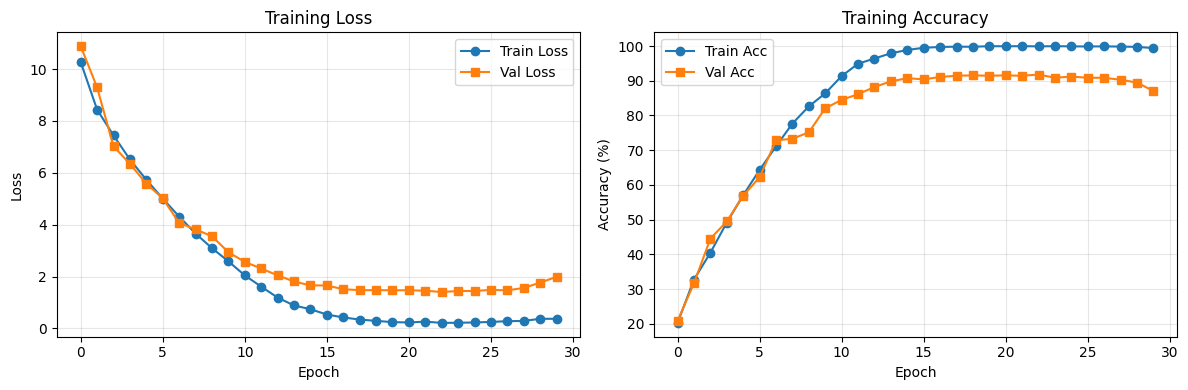

In [21]:
# Cell 18: Improved Training with Better Hyperparameters
print("🎯 Starting Improved Training with Better Settings...")

if len(label_to_name) > 0:
    num_classes = len(label_to_name)
    embedding_size = 512

    print(f"\n📊 Training Configuration:")
    print(f"  Number of classes: {num_classes}")
    print(f"  Embedding size: {embedding_size}")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Average images per class: {len(train_dataset)/num_classes:.1f}")

    # Reinitialize model
    model = FaceNet(embedding_size=embedding_size).to(device)

    # Use smaller margin and scale for few-shot learning
    cosface_loss = CosFaceLoss(num_classes, embedding_size, margin=0.2, scale=32).to(device)

    # Optimizer with better settings
    optimizer = optim.AdamW([
        {'params': model.parameters(), 'lr': 0.0005},
        {'params': cosface_loss.parameters(), 'lr': 0.0005}
    ], weight_decay=1e-4)

    # Learning rate scheduler with warmup
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)

    # Training parameters
    num_epochs = 30
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    print(f"\n{'='*60}")
    print("🚀 Starting Improved Training")
    print(f"{'='*60}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {optimizer.param_groups[0]['lr']}")
    print(f"  Margin: {cosface_loss.margin}")
    print(f"  Scale: {cosface_loss.scale}")
    print(f"{'='*60}")

    # Training loop
    for epoch in range(1, num_epochs + 1):
        print(f"\n📅 Epoch {epoch}/{num_epochs}")

        # Train
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0

        for batch_idx, (images, batch_labels) in enumerate(train_loader):
            images, batch_labels = images.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            embeddings = model(images)
            loss, logits = cosface_loss(embeddings, batch_labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(logits, 1)
            correct = (predicted == batch_labels).sum().item()

            epoch_loss += loss.item()
            epoch_correct += correct
            epoch_total += batch_labels.size(0)

            if batch_idx % 20 == 0:
                batch_acc = 100. * correct / batch_labels.size(0)
                print(f'  Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}, Acc={batch_acc:.1f}%')

        # Calculate epoch metrics
        avg_train_loss = epoch_loss / len(train_loader)
        avg_train_acc = 100. * epoch_correct / epoch_total
        train_losses.append(avg_train_loss)
        train_accs.append(avg_train_acc)

        # Validate
        avg_val_loss, avg_val_acc = validate(model, val_loader, cosface_loss, device)
        val_losses.append(avg_val_loss)
        val_accs.append(avg_val_acc)

        # Update learning rate
        scheduler.step()

        print(f"\n📊 Epoch {epoch} Summary:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%")
        print(f"  Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%")
        print(f"  LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if epoch == 1 or avg_val_acc >= max(val_accs):
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'cosface_state_dict': cosface_loss.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'train_acc': avg_train_acc,
                'val_acc': avg_val_acc,
                'label_to_name': label_to_name,
                'num_classes': num_classes,
                'embedding_size': embedding_size
            }
            torch.save(checkpoint, 'improved_cosface_model.pth')
            print(f"  💾 Saved improved model (Acc: {avg_val_acc:.2f}%)")

    print(f"\n{'='*60}")
    print("🎉 Improved Training Complete!")
    print(f"{'='*60}")
    print(f"  Best Val Accuracy: {max(val_accs):.2f}%")
    print(f"  Final Val Accuracy: {val_accs[-1]:.2f}%")

    # Plot results
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc', marker='o')
    plt.plot(val_accs, label='Val Acc', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("❌ No data for training!")

##cell-13: Face Verification Evaluation

In [22]:
# Cell 19: Face Verification Test
print("🧪 Testing Face Verification...")

def test_face_verification(model, dataset, num_pairs=1000):
    """
    Test face verification (same/different person)
    """
    model.eval()

    # Group indices by label
    label_to_indices = {}
    for idx, (_, label) in enumerate(dataset):
        if label not in label_to_indices:
            label_to_indices[label] = []
        label_to_indices[label].append(idx)

    labels_list = list(label_to_indices.keys())

    same_pairs = []
    diff_pairs = []

    # Generate pairs
    for _ in range(num_pairs // 2):
        # Same person pairs
        label = random.choice(labels_list)
        while len(label_to_indices[label]) < 2:
            label = random.choice(labels_list)

        idx1, idx2 = random.sample(label_to_indices[label], 2)
        same_pairs.append((idx1, idx2, 1))  # 1 = same person

        # Different person pairs
        label1, label2 = random.sample(labels_list, 2)
        idx1 = random.choice(label_to_indices[label1])
        idx2 = random.choice(label_to_indices[label2])
        diff_pairs.append((idx1, idx2, 0))  # 0 = different person

    all_pairs = same_pairs + diff_pairs
    random.shuffle(all_pairs)

    # Evaluate
    correct = 0
    total = 0

    with torch.no_grad():
        for idx1, idx2, label in all_pairs:
            img1, _ = dataset[idx1]
            img2, _ = dataset[idx2]

            img1 = img1.unsqueeze(0).to(device)
            img2 = img2.unsqueeze(0).to(device)

            emb1 = model(img1)
            emb2 = model(img2)

            # Cosine similarity
            cos_sim = F.cosine_similarity(emb1, emb2)

            # Threshold for decision
            threshold = 0.5
            pred = 1 if cos_sim.item() > threshold else 0

            if pred == label:
                correct += 1
            total += 1

    accuracy = 100. * correct / total
    return accuracy

if 'model' in locals():
    print("\nRunning face verification test...")
    verif_accuracy = test_face_verification(model, val_dataset, num_pairs=500)
    print(f"✅ Face Verification Accuracy: {verif_accuracy:.2f}%")
    print(f"\n💡 Interpretation:")
    print(f"  This measures if two faces are the same person or not.")
    print(f"  Much more meaningful for LFW than classification accuracy.")
else:
    print("Model not available. Train first!")

🧪 Testing Face Verification...

Running face verification test...
✅ Face Verification Accuracy: 89.00%

💡 Interpretation:
  This measures if two faces are the same person or not.
  Much more meaningful for LFW than classification accuracy.


##Direct Download to Local Machine

In [25]:
import zipfile
import os
from datetime import datetime

# Create a timestamp for the zip file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f'cosface_lfw_model_{timestamp}.zip'

print(f"Creating zip file: {zip_filename}")

# Create zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model files
    for file in ['best_cosface_model.pth', 'cosface_final_model.pth',
                 'face_embeddings.npy', 'face_labels.npy']:
        if os.path.exists(file):
            zipf.write(file)
            print(f"➕ Added: {file}")

    # Add Python code for loading the model
    code = '''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
from PIL import Image

class FaceNet(nn.Module):
    def __init__(self, embedding_size=512, pretrained=True):
        super(FaceNet, self).__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        embedding = self.fc(x)
        return embedding

def load_model(checkpoint_path, device="cuda" if torch.cuda.is_available() else "cpu"):
    """Load the trained CosFace model"""
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    model = FaceNet(embedding_size=checkpoint["embedding_size"])
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return model, transform, checkpoint

print("Model loading code saved to load_model.py")
'''

    zipf.writestr('load_model.py', code)

    # Add a README file
    # Get the number of classes if available
    try:
        if 'label_to_name' in locals():
            num_classes = len(label_to_name)
        else:
            num_classes = 'Unknown'
    except:
        num_classes = 'Unknown'

    readme = f"""# CosFace Model for LFW Dataset

## Model Information
- Training Date: {timestamp}
- Number of Classes: {num_classes}
- Embedding Size: 512
- Framework: PyTorch

## Files Included:
1. best_cosface_model.pth - Best model checkpoint
2. cosface_final_model.pth - Final model checkpoint
3. face_embeddings.npy - Face embeddings from validation set
4. face_labels.npy - Corresponding labels for embeddings
5. load_model.py - Code to load and use the model

## How to Use:
```python
from load_model import load_model
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, transform, checkpoint = load_model('best_cosface_model.pth', device)

# Get label mappings
label_to_name = checkpoint['label_to_name']
num_classes = checkpoint['num_classes']

SyntaxError: incomplete input (ipython-input-2638226228.py, line 81)

In [23]:
import zipfile
import os
from datetime import datetime

# Create a timestamp for the zip file
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
zip_filename = f'cosface_lfw_model_{timestamp}.zip'

print(f"Creating zip file: {zip_filename}")

# Create zip file
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Add model files
    for file in ['best_cosface_model.pth', 'cosface_final_model.pth',
                 'face_embeddings.npy', 'face_labels.npy']:
        if os.path.exists(file):
            zipf.write(file)
            print(f"➕ Added: {file}")

    # Add Python code for loading the model
    code = """
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
from PIL import Image

class FaceNet(nn.Module):
    def __init__(self, embedding_size=512, pretrained=True):
        super(FaceNet, self).__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, embedding_size),
            nn.BatchNorm1d(embedding_size)
        )

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        embedding = self.fc(x)
        return embedding

def load_model(checkpoint_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
    \"\"\"Load the trained CosFace model\"\"\"
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)

    model = FaceNet(embedding_size=checkpoint['embedding_size'])
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((160, 160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return model, transform, checkpoint

print("Model loading code saved to load_model.py")
"""

    zipf.writestr('load_model.py', code)

    # Add a README file
    readme = f"""# CosFace Model for LFW Dataset

## Model Information
- Training Date: {timestamp}
- Number of Classes: {len(label_to_name) if 'label_to_name' in locals() else 'Unknown'}
- Embedding Size: 512
- Framework: PyTorch

## Files Included:
1. best_cosface_model.pth - Best model checkpoint
2. cosface_final_model.pth - Final model checkpoint
3. face_embeddings.npy - Face embeddings from validation set
4. face_labels.npy - Corresponding labels for embeddings
5. load_model.py - Code to load and use the model

## How to Use:
```python
from load_model import load_model
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model, transform, checkpoint = load_model('best_cosface_model.pth', device)

# Get label mappings
label_to_name = checkpoint['label_to_name']
num_classes = checkpoint['num_classes']

SyntaxError: incomplete input (ipython-input-1468287669.py, line 72)